In [1]:
import os
from matplotlib import pyplot as plt
import numpy as np
os.chdir('/Users/rraj/PythonFunctions/DCNet/')
os.getcwd()

'/Users/rraj/PythonFunctions/DCNet'

In [2]:
import torch
from torchvision.datasets import MNIST
from torchvision import transforms
from tqdm import tqdm

mnist_data = MNIST(
    root = 'data',
    train = True,                         
    transform = transforms.ToTensor(), 
    download = True,            
)


In [3]:
from initialization import DatasetInitializer, IdentityInitializer
from layers import DiscriminationModule, ClassificationModule
from loading import SequentialLoader
from metrics import Conncetedness, Consistency

metric1 = Conncetedness()
metric2 = Consistency()
loader = SequentialLoader(mnist_data, num_classes=10)


In [4]:
train_size = 500
precisions = []
recalls = []
consistencies = []

for epoch in range(100, 600, 100):
    metric1.reset()
    metric2.reset()
    
    precision = []
    recall = []
    consistency = []
    
    beta = 1 - (1/epoch)
    module_d = DiscriminationModule(500, DatasetInitializer(dataset=mnist_data, num_classes=10), beta=beta)
    module_c = ClassificationModule(500, IdentityInitializer())
    
    for epoch_number in tqdm(range(train_size//epoch), desc=str(epoch)):
        module_c.teaching('on') if epoch_number == 0 else module_c.teaching('off')
        for x in loader(epoch):
            y_ = module_d(x)
            module_c(y_)
        
        module_d.organize()
        module_c.organize()
        metric1.update(module_c.recurrent_weights, module_d.labels(10))
        metric2.update(module_d.labels(10))
        
        p, r = metric1.compute()
        c = metric2.compute()
        precision.append(p)
        recall.append(r)
        consistency.append(c)
    
    precisions.append(precision)
    recalls.append(recall)
    consistencies.append(consistency)

500: 100%|██████████| 10/10 [12:15<00:00, 73.57s/it]


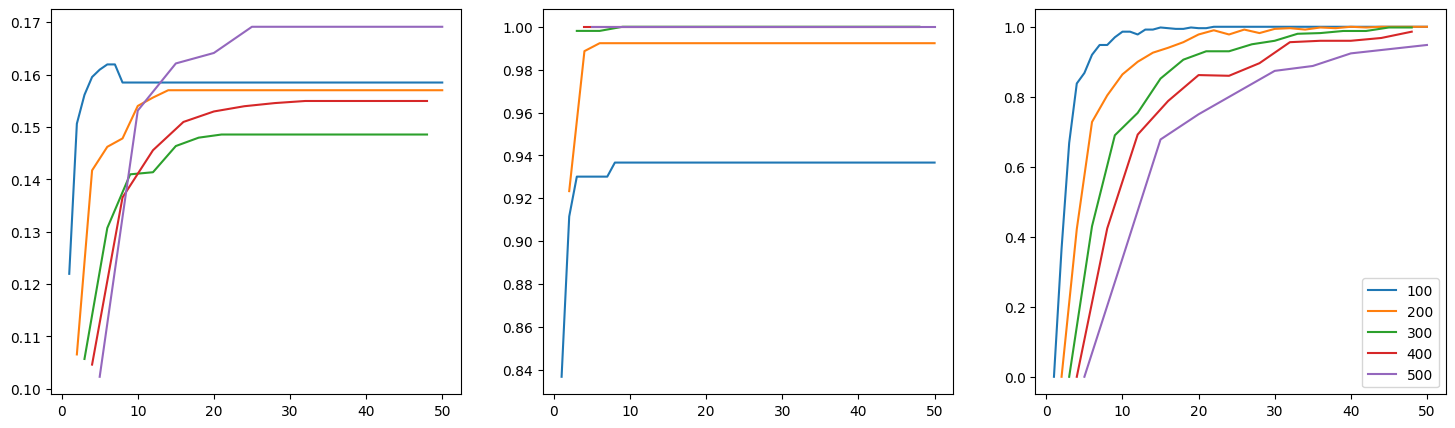

In [5]:
fig, ax = plt.subplots(1, 3, figsize=(18,5))
for i in range(5):
    x = [*range(i+1, train_size//100+1, i+1)]
    ax[0].plot(x, precisions[i], label=str(100*(i+1)))
    ax[1].plot(x, recalls[i], label=str(100*(i+1)))
    ax[2].plot(x, consistencies[i], label=str(100*(i+1)))
plt.legend()

In [4]:
train_size = 10000
epochs = [300]*5 + [200]*10 + [100]*15 + [50]*30 + [100]*50
#epochs = [50]*200
precisions = []
recalls = []
consistency = []
pruned_weights = []
beta = 1 - 1/300
#t_counter = 0

module_d = DiscriminationModule(500, DatasetInitializer(mnist_data, num_classes=10), beta=beta, alpha=1.2)
module_c = ClassificationModule(500, IdentityInitializer(), pruner_alpha=5.0)
#module_c.pruning('on')
metric1.reset()
for eidx, epoch in tqdm(enumerate(epochs), total=len(epochs)):
    for x in loader(epoch):
        y_ = module_d(x)
        y = module_c(y_)
        
    module_d.organize() 
    module_c.organize()
    if eidx > 60:
        module_c.pruning('on')
        pruned_weights.append(module_c.pruned_weights)
    #module_c.pruning('on') if eidx > 60 else None
    #module_c.teach() if eidx > 0 and eidx%10 == 0 else None
    metric1.update(module_c.recurrent_weights, module_d.labels(10))
    metric2.update(module_d.labels(10))
    p, r = metric1.compute()
    precisions.append(p)
    recalls.append(r)
    consistency.append(metric2.compute())
    
#print(f"{t_counter=}")

100%|██████████| 110/110 [26:44<00:00, 14.58s/it]


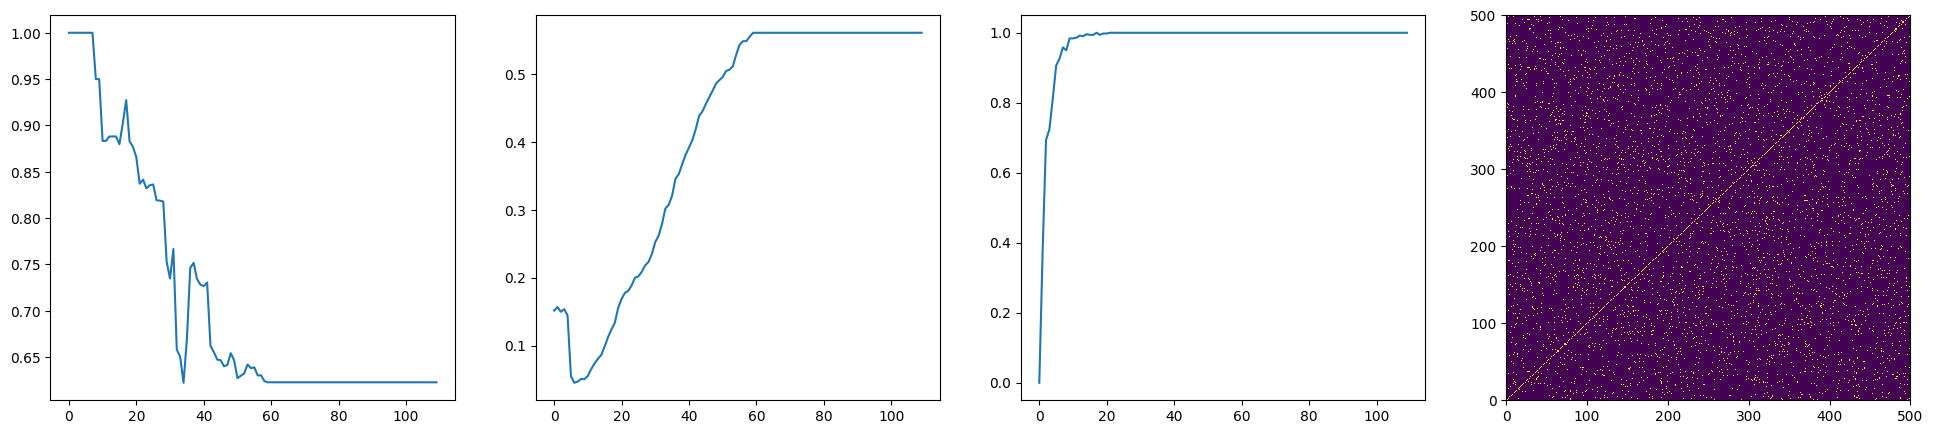

In [5]:
#[100]*100
fig, ax = plt.subplots(1, 4, figsize=(24, 5))
ax[0].plot(precisions)
ax[1].plot(recalls)
ax[2].plot(consistency)
ax[3].pcolormesh(module_c.recurrent_weights)

In [6]:
for w in pruned_weights:
    print(torch.sum(module_c.recurrent_weights - w).item())


-12282.0
-11782.0
-11292.0
-10800.0
-10456.0
-10010.0
-9626.0
-9290.0
-8862.0
-8584.0
-7888.0
-7430.0
-7112.0
-6882.0
-6602.0
-6522.0
-5976.0
-5784.0
-5526.0
-5118.0
-4904.0
-4578.0
-4074.0
-3926.0
-3722.0
-3384.0
-3208.0
-3036.0
-2574.0
-2348.0
-2218.0
-2106.0
-1992.0
-1914.0
-1804.0
-1716.0
-1498.0
-1392.0
-1232.0
-1156.0
-1014.0
-906.0
-836.0
-702.0
-578.0
-396.0
-278.0
-106.0
0.0


/var/folders/b9/8km7dn7s35bfc4y81hgxnfj9d52_hx/T/ipykernel_38299/952859192.py:14: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3575.)
  label_assignments = torch.tensor(label_counts).T[l]


IndexError: index 0 is out of bounds for dimension 0 with size 0

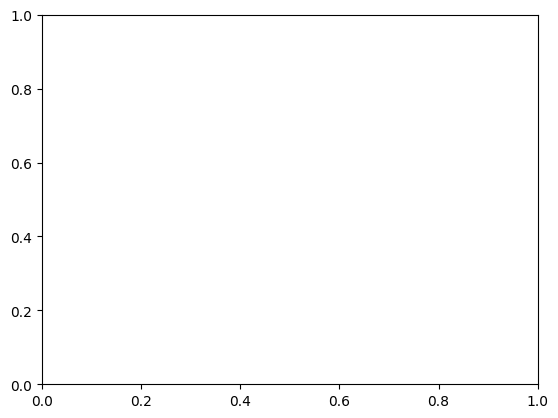

In [18]:
all_labels = module_d.labels(10)
label_counts = []
for row in module_c.connections.T:
    idxs = row.nonzero().flatten()
    if len(idxs) > 2:
        row_label_count = torch.empty(10, dtype=int)
        row_labels = all_labels[idxs]
        labels, counts = torch.unique(row_labels, return_counts=True)
        row_label_count[labels] = counts
        label_counts.append(row_label_count.tolist())
fig, ax = plt.subplots()
bottom = torch.zeros(len(label_counts))
for l in range(10):
    label_assignments = torch.tensor(label_counts).T[l]
    ax.bar(range(len(label_counts)), label_assignments.tolist(), label=str(l), bottom=bottom.tolist())
    bottom += label_assignments
plt.legend()

In [54]:
train_size = 30000
degrees = []

for epoch in range(100, 600, 100):
    degree = []
    
    beta = 1 - (1/epoch)
    module_d = DiscriminationModule(500, DatasetInitializer(dataset=mnist_data, num_classes=10), beta=beta)
    module_c = ClassificationModule(500, IdentityInitializer())
    
    for epoch_number in tqdm(range(train_size//epoch), desc=str(epoch)):
        for x in loader(epoch):
            y_ = module_d(x)
            module_c(y_)
        
        module_d.organize()
        module_c.organize()
        degree.append(torch.sum(module_c.recurrent_weights).item())
    
    degrees.append(degree)

500: 100%|██████████| 60/60 [1:06:05<00:00, 66.09s/it]


Text(0.5, 0, 'Organize interval')

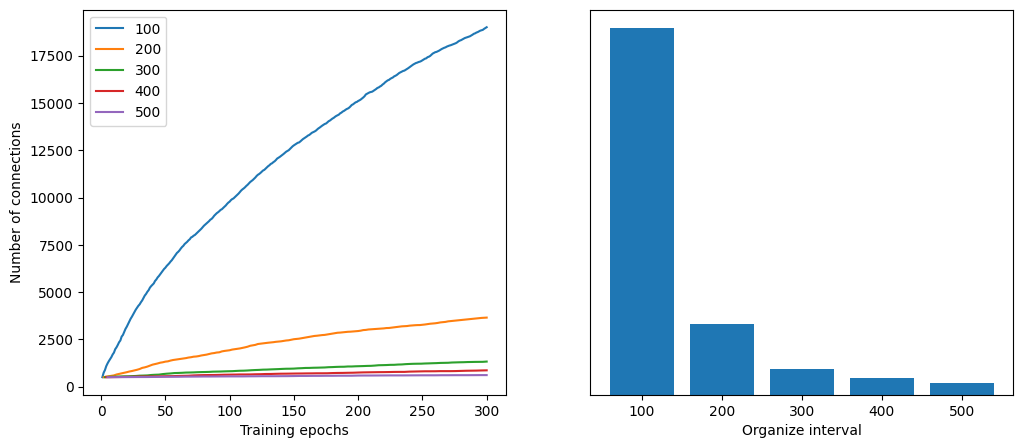

In [89]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
for i in range(5):
    x = [*range(i+1, 30000//100+1, i+1)]
    ax[0].plot(x, degrees[i], label=str(100*(i+1)))
plt.sca(ax[0])
plt.legend()
plt.xlabel("Training epochs")
plt.ylabel("Number of connections")

ax[1].bar(range(5), [x[-1] for x in degrees])
plt.sca(ax[1])
plt.xticks(range(5), range(100, 600, 100))
plt.yticks([])
plt.xlabel("Organize interval")

In [7]:
epochs = [300]*5 + [200]*10 + [100]*15 + [50]*30 + [100]*10 + [300]*10
for eidx, epoch in tqdm(enumerate(epochs), total=80):
    print(epoch , end=" ")

100%|██████████| 80/80 [00:00<00:00, 300666.95it/s]

300 300 300 300 300 200 200 200 200 200 200 200 200 200 200 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 100 100 100 100 100 100 100 100 100 100 300 300 300 300 300 300 300 300 300 300 